# Captain Cook: the fabulous recipes explorator


**This notebook shows how we obtain and analyzed the data for the cooking recipes dataset.**
Some scripting with `PERL` and `BASH`was needed for the cleaning part, please have a look in **DataCLeaning.iypnb** to understand the data crawling/cleaning.

In [36]:
# Basic imports
import re
import os.path
import numpy as np
import scipy as sp
import pandas as pd

# Map-related imports
import json
import branca
import folium
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

# Plot-related imports
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual

# NLP
import nltk
nltk.download('punkt');
nltk.download('averaged_perceptron_tagger');

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to /home/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# General parameters
%matplotlib inline
plt.style.use('seaborn')#switch to seaborn style
plt.rcParams["figure.figsize"] = [16,10]

DATA_FOLDER = './data/'

# 1. Data Loading
  
The Data has been fetched and cleaned with `BASH`scripts, please look in the *dataCleaning* section to understand how this was achieved.  

**Home made fetched dataset:**

In [3]:
# Importing ingredients to Pandas DF
allrecipes_df = pd.read_csv(DATA_FOLDER + 'allrecipes.csv', sep='\t',  header=None, encoding = "utf-8")
allrecipes_df.columns = ['ID', 'Region', 'Title', 'Ingredients', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
allrecipes_df['kcal'] = pd.to_numeric(allrecipes_df['kcal'], errors='coerce')
allrecipes_df['carb'] = pd.to_numeric(allrecipes_df['carb'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['fat'] = pd.to_numeric(allrecipes_df['fat'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['protein'] = pd.to_numeric(allrecipes_df['protein'], errors='coerce')
allrecipes_df['sodium'] = pd.to_numeric(allrecipes_df['sodium'], errors='coerce') / 1000.0
allrecipes_df['cholesterol'] = pd.to_numeric(allrecipes_df['cholesterol'], errors='coerce')

# Remove any rows which isn't properly formatted
allrecipes_df = allrecipes_df.dropna()

# Remove any duplicated lines
allrecipes_df = allrecipes_df.drop_duplicates().set_index('ID')

# Printing
allrecipes_df.head(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [4]:
# Importing descriptions to Pandas DF
allrecipes_desc_df = pd.read_csv(DATA_FOLDER + 'allrecipes_desc.csv', sep='£',  header=1, encoding = "utf-8",  engine='python')
allrecipes_desc_df.columns = ['ID', 'Description']

# Remove any duplicated lines
allrecipes_desc_df = allrecipes_desc_df.drop_duplicates().set_index('ID')

allrecipes_desc_df.head(5)

,Description
ID,
beed004e2a1772ba0db9da913f54122e,"Place bratwurst, beer, onion, and ketchup in ..."
96353c72421bd74096277c6cf8b17097,"Combine the hot sauce, butter, vinegar, Worce..."
ee659a6a5e69834b60744cc3e103729e,Preheat oven to 350 degrees F (175 degrees C)...
1afe62458129f741d989b89d6ae8d08c,Heat a large skillet over medium-high heat an...
7b93a05f2c4a9ff967957f62fe5c6622,"In a large bowl, dissolve the sugar in warm w..."


In [5]:
print("Number of recipes:", len(allrecipes_df.index.unique()))

Number of recipes: 15894


**Provided Dataset**

This dataset was provided with the assignment and cleaned with the provided `Perl` scripts. 

Thanks to the scripts, we obtain two datasets:

1. `cleaned_ing.csv` contains the list of ingredients for each recipe,
2. `cleaned_nutri.csv` contains the corresponding nutritional values.

Our objective is to merge these two sets to obtain a unique set with all useful informations.

In [6]:
# Importing ingredients to Pandas DF
ing_df = pd.read_csv(DATA_FOLDER + 'cleaned_ing.csv', sep='\t',  header=None, encoding = "utf-8")
ing_df.columns = ['ID', 'Title', 'Ingredients']

# Importing nutritional values to Pandas DF
nutri_df = pd.read_csv(DATA_FOLDER + 'cleaned_nutri.csv', sep='\t',  header=None, encoding = "utf-8")
nutri_df.columns = ['ID', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Merging
ing_df = ing_df.set_index('ID')
nutri_df = nutri_df.set_index('ID')
provided_df = ing_df.merge(nutri_df, on='ID', how='inner')

# Drop NaNs and duplicate lines
provided_df = provided_df.dropna().drop_duplicates()

provided_df.head()

,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,1 teaspoon onion powder|1 tablespoon Tabasco s...,?,?,?,?,?,?
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,1 butternut squash|2 tablespoons brown sugar|1...,536,86.4,23.6,6.5,483,61
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,2 pounds lean pork|1/2 pound pork fatback|3 te...,?,?,?,?,?,?
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,?,?,?,?,?,?


We can observe that some nutritional values are missing, which can be solved either by removing the lines or by trying to calculate these values from the given ingredients.

As trying to calculate the values from ingredients with different units (i.e. grams, cups, tbsp, etc) requires a set of informations that we do not have, we decided to leave these lines as they are for now. 

In [7]:
# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
provided_df['kcal'] = pd.to_numeric(provided_df['kcal'], errors='coerce')
provided_df['carb'] = pd.to_numeric(provided_df['carb'], errors='coerce')
provided_df['fat'] = pd.to_numeric(provided_df['fat'], errors='coerce')
provided_df['protein'] = pd.to_numeric(provided_df['protein'], errors='coerce')
provided_df['sodium'] = pd.to_numeric(provided_df['sodium'], errors='coerce')
provided_df['cholesterol'] = pd.to_numeric(provided_df['cholesterol'], errors='coerce')

# Insert Region column to match the other DF
provided_df.insert(loc=1, column='Region', value=np.nan)
provided_df.head(5)

,Title,Region,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,NaN,1 teaspoon onion powder|1 tablespoon Tabasco s...,NaN,NaN,NaN,NaN,NaN,NaN
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,NaN,1 butternut squash|2 tablespoons brown sugar|1...,536.0,86.4,23.6,6.5,483.0,61.0
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,NaN,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,NaN,2 pounds lean pork|1/2 pound pork fatback|3 te...,NaN,NaN,NaN,NaN,NaN,NaN
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,NaN,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Number of recipes:", len(provided_df.index.unique()))

Number of recipes: 31376


In [9]:
# Concatenate the 2 DF and drop any duplicated lines, it is possible since some data come from the same website!
recipes_df = allrecipes_df.append(provided_df, sort=False).drop_duplicates()
recipes_df['Region'] = recipes_df['Region'].astype('category')

recipes_df.head()

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [10]:
print("Number of total recipes:", len(recipes_df.index.unique()))

Number of total recipes: 46999


In [11]:
len(recipes_df[recipes_df['Region']=='italian'])/365

6.841095890410959

We see that the total number of recipes is enough to eat italian recipes everyday for almost 7 years!!  
We can save this DataFrame to be use later on.

In [12]:
recipes_df.to_csv(DATA_FOLDER + 'recipes_df.csv', sep='\t', encoding='utf-8')

---
# 2. Ingredient parsing
In this part we are trying to get a list of ingredients for each recipe. This list should be clean, which means it should contain only the names of the ingredients and no other informations, like quantities.

To do this, first we cleaned the list of ingredients by applying a low-case and by removing a set of words chosen manually (contained in `black_list`), then we used the natural language processing library `nltk` to remove words different from nouns.

In [13]:
# Copy for test
recipes_copy = recipes_df.copy()

# lowercase to be insensitive
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.lower()

# Coerce filtering, removing any occurence of these words as a first filter
black_list = ['inches','inch','medium','pounds','pound','ounces','ounces','fluid','ground','tablespoons','tablespoon','cups','cup','teaspoons','teaspoon', 'all-purpose', '\(.*\)']
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].replace(black_list, '', regex=True)

# Remove non alphabetic values expect of '|' which is the seperating char
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.replace('[^a-zA-Z  -]+', ' ')

# Retrieve list of ingredients in overall
keywords_list = recipes_copy['Ingredients'].str.split(" ", expand=True).stack().unique()
print("Number of uncleaned ingredients:", len(keywords_list))

Number of uncleaned ingredients: 6814


In [14]:
### Retrieve bad ingredients
# NLP-related imports
nltk.download('punkt');
nltk.download('averaged_perceptron_tagger');

# NLP to identify only verbs
tokens = nltk.word_tokenize(' '.join(keywords_list))
tagged = nltk.pos_tag(tokens)

# Fetching the list of non correct word
gray_list = [word for word,pos in tagged if not(pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

# Further filtering by removing gray_listed word with regex
ingredient_serie = recipes_copy['Ingredients'].replace(gray_list, '')

# Retrieve list of ingredients in overall
keywords_list = ingredient_serie.str.split(" ", expand=True).stack().unique()

# NLP to identify only nouns
tokens = nltk.word_tokenize(' '.join(keywords_list))
tagged = nltk.pos_tag(tokens)
nouns = [word for word,pos in tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

# We need to remove word that a smaller than 3 letters, as we suppose they are not ingredients
ing_list = [item for item in nouns if len(item) > 3]

[nltk_data] Downloading package punkt to /home/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


At this point, we have a list of ingredients contained in `ing_list`, which can be used to filter our dataset. Unfortunately, as we are going to see below, some ingredients are not spelled correctly while others are not ingredients at all.

In [15]:
# Take original ingredients list and split each word to count recurrencies
ing_ds = recipes_copy['Ingredients'].str.split(" ", expand=True) \
                                        .stack().value_counts()  \
                                        .to_frame(name='count')  \
                                        .reset_index()

# Keeping only the ingredient in the previous list
ing_ds = ing_ds[ing_ds['index'].isin(ing_list)].reset_index(drop=True)

#ing_ds.sort_values(by='index') # if you want to see similar words
ing_ds.head(21)

,index,count
0,salt,22663
1,pepper,20349
2,butter,13016
3,onion,11929
4,flour,11890
5,taste,10339
6,water,10208
7,powder,9549
8,sauce,7413
9,milk,7393


We can see that the words `powder`, `taste` and `sauce` are contained in the ten most recurring words, although they are not ingredients. These words should then be parsed by hand and removed to obtain a list that is ingredients-only.

We can also notice that some ingredients are duplicated due to different spellings (i.e. `onion` and `onions`). 

We implement the Levenshtein distance, hence we canmerge similar words by finding a metric that calculates the distance between words. As such the similar words should have close values given by the metric, if they are close enough, we conclude it is the same word.

In [16]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

**At this point we clean the data by hand**: the only issue we have now is the similar words which can be fixed by the suggested methods above.

# Reading from the hand cleaned Dataset
with open(DATA_FOLDER + 'cleaned_list') as f:
    hand_ing_list = f.read().splitlines()

# For every word in the list,
# we cross compute the Levenshtein distance
matrix = np.array([[levenshtein(item1, item2) for item1 in keywords_list] for item2 in keywords_list])

# Any difference of 1 character is consider the same word
normed_mat = (matrix <= 1).astype(int)
normed_mat

The above matrix represents a sort of adjacency for a graph network, by taking the first non-null value in each row we get a vector defining a dictionnary. We take the first non-null value since the list was ordered by frequency occurences, we assume if a word is more frequent it should be the correct spelling.

# Take the first non null value
vec = normed_mat.argmax(axis=0)
vec

# From the list above we construct a list
transformed_list = [keywords_list[i] for i in vec]

# Applying the Levenshtein distance,
# similar words should be map to the same
ing_dict = dict(zip(keywords_list, transformed_list))
ing_dict

Now we have a nice dictionnary that will help us to finally clean the ingredients list.

# Saving
np.save(DATA_FOLDER + 'full_ing_dict.npy', ing_dict) 

In [17]:
# Load csv file 'hand' cleaned
with open(DATA_FOLDER + 'cleaned_list') as f:
    ing_list = f.read().splitlines()
    
# Load the dictionnary that correct the name mispelled
ing_dict = np.load(DATA_FOLDER + 'ing_dict.npy').item()

In [18]:
# First we lowercase avery word in the list
recipes_copy = recipes_df.copy()
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.lower()

# Remove non alphabetic values expect of '|' which is the seperating char
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.replace('[^a-zA-Z ]+', ' ')

In [19]:
# This step is needed to clean the dataset ingredient!
# Function that apply the cleaning dictionnary on every word in ingredients column for each recipes
def matcher(k):
    x = (i for i in ing_dict if i in k.split(' '))
    return '|'.join(map(ing_dict.get, x))

# Cleaned!!!
recipes_copy['Cleaned_Ing'] = recipes_copy['Ingredients'].map(matcher)
recipes_copy

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Cleaned_Ing
ID,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,cups persimmon pulp eggs cup white sugar...,278.0,53.9,3.8,7.8,0.224,35.0,butter|flour|milk|eggs|persimmon
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,cup all purpose flour tablespoons cornstar...,409.0,43.0,18.8,17.3,0.407,54.0,salt|pepper|flour|powder|cumin|lime|corn|mayon...
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,bratwurst fluid ounce cans or bottles b...,377.0,12.8,27.4,13.8,1.046,69.0,onion|beef
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,cup hot pepper sauce such as frank s redhot...,104.0,0.4,11.6,0.2,0.576,31.0,salt|pepper|butter|powder|vinegar|worcestershire
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,cup butter softened cups brown sugar ...,140.0,14.9,8.7,1.5,0.076,22.0,salt|butter|flour|powder|milk|eggs|vanilla|cho...
1afe62458129f741d989b89d6ae8d08c,us,Kendra's Maid-Rite Sandwiches,pounds ground beef chopped onion cup ket...,244.0,27.0,8.9,13.4,0.483,34.0,salt|onion|vinegar|beef|worcestershire|hamburger
7b93a05f2c4a9ff967957f62fe5c6622,us,Amish White Bread,cups warm water degrees f degrees c cu...,168.0,30.7,2.9,4.4,0.147,0.0,salt|flour|water|bread|yeast
fb0673097182df2dd7f7355b0e41693a,us,Buffalo Chicken Dip,ounce cans chunk chicken drained oun...,284.0,8.6,22.6,11.1,0.552,54.0,pepper|chicken|cream|celery|cheddar|cracker
1eaa22e1674b18dfbd30ec384931e9b1,us,Roast Sticky Chicken-Rotisserie Style,teaspoons salt teaspoons paprika teaspoo...,586.0,3.7,34.3,61.7,1.351,194.0,salt|pepper|onion|powder|onion|chicken


**The ingredient is now perfectly cleaned we can do some neat analysis on it**

----

# 3. Cooking time study-case

In this part we would like to analyze the cooking time of the recipes to be able to classify which regions have the highest and lowest cooking time.

In [20]:
# Extract all timing from recipes
timing_df = allrecipes_desc_df['Description'].str.extractall(r'(\d+) minutes|(\d+) hour|hours')
timing_df.columns = ['minutes', 'hours']

#Replace Nan by 0 and switch to int type
timing_df = timing_df.fillna(0).astype(int)

#Sum the number of minutes to get the recipe time
timing_df['Time (min)'] = timing_df['minutes']+timing_df['hours']*60

timing_df.head()

minutes  hours  Time (min)
ID                               match                            
beed004e2a1772ba0db9da913f54122e 0            0      4         240
                                 1            5      0           5
ee659a6a5e69834b60744cc3e103729e 0           12      0          12
1afe62458129f741d989b89d6ae8d08c 0           20      0          20
7b93a05f2c4a9ff967957f62fe5c6622 0            0      1          60

In [21]:
# Sum the total amount of time for each recipe
time_recipe = timing_df.groupby('ID').agg('sum')
time_recipe = time_recipe.drop(['minutes','hours'], axis=1)

time_recipe.head()

,Time (min)
ID,
00035a69b44a9dd1f88f2bb5faced261,90
000d31e632cab9e6902f05196354a007,660
0015417d2473d92a56da28883a27aff3,120
001cf1a5a0d1914f958cb2c823df6121,8
001f5efe07f4c72b4aaf846ec7616aba,13


This data will be later used on a map displaying the distribution of the cooking time around the world.

---

# 4. Merging
Finally, we can merge everything to a single DataFrame to be used in visualization

In [22]:
# Merging Cooking Time
cleaned_df = recipes_df.merge(time_recipe, on='ID', how='left')

# Cleaning ingredient and ingredient substition
# This is not yet implemented but we are close to achieve this
cleaned_df.to_csv(DATA_FOLDER + 'cleaned_df.csv', sep='\t', encoding='utf-8')
cleaned_df.sample(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Time (min)
ID,,,,,,,,,,
49783e47a2795c0fc9d7daf47dfb47c4,mexican,Cheeseburger Quesadilla,"1 teaspoon butter |1/2 small yellow onion, cho...",1054.0,61.5,61.8,59.9,1.728,196.0,22.0
b2beca10f2ea5458d41adc965d202c8d,NaN,Fresh Mint and Cilantro Melon Salad Recipe,4 cups 1-inch chunks honeydew|1 tablespoon fre...,27.0,6.7,0.1,0.4,13.000,0.0,NaN
ad1d148f6c9ad9fe4c4896ab7a3a1a84,australian,"Strawberry, Kiwi, and Spinach Salad",2 tablespoons raspberry vinegar |2 1/2 tablesp...,169.0,10.3,14.2,2.3,0.025,0.0,NaN
fac47e071e69b311893554425d754097,NaN,Cod with Italian Crumb Topping Recipe,1/4 cup fine dry bread crumbs|2 tablespoons gr...,131.0,7.0,2.9,18.1,148.000,39.0,NaN
dfe0b7916a802f677431b4f8d0b52997,mexican,Sausage and Pepper Sunrise Burrito,"4 links breakfast pork sausage, cut into 1/2-i...",341.0,30.2,19.6,20.4,0.582,235.0,NaN


# 5. Analysis

This part presents some basic statistical analysis of the data.

First we analyse the data by region and observe *mean*, *median*, *min* and *max* for each nutritional value.

In [23]:
# Some classic analysis
stats_regions = cleaned_df.groupby('Region')
stats_regions = stats_regions.agg({'kcal' : ['mean', 'median', 'min', 'max'],
                                       'carb' : ['mean', 'median', 'min', 'max'],
                                       'fat' : ['mean', 'median', 'min', 'max'],
                                       'protein' : ['mean', 'median', 'min', 'max'],
                                       'sodium' : ['mean', 'median', 'min', 'max'],
                                       'cholesterol' : ['mean', 'median', 'min', 'max'],
                                       'Time (min)' : ['mean', 'median', 'min', 'max']})
stats_regions.sort_values([('kcal', 'mean')], ascending=False).head()

kcal                            carb                     \
                  mean median   min     max       mean median  min    max   
Region                                                                      
malaysian   435.600000  427.0  33.0  1238.0  30.422857  26.70  1.7  113.2   
portuguese  402.173333  378.0  27.0  2266.0  33.832000  28.50  4.0  108.6   
italian     391.215459  360.0   4.0  1641.0  34.242171  29.90  0.0  174.8   
indonesian  387.648649  401.0  65.0   716.0  29.056757  19.60  6.5   94.2   
french      377.932609  319.5   9.0  3274.0  27.991739  22.05  0.4  240.9   

                  fat          ...   sodium         cholesterol              \
                 mean median   ...      min     max        mean median  min   
Region                         ...                                            
malaysian   24.091429  19.80   ...    0.011   3.031   90.914286   66.0  0.0   
portuguese  20.009333  17.10   ...    0.003  10.693   84.986667   67.0  0.0   
italian     19.998438  17.20   ...    0.001   7.648   71.113736   50.0  0.0   
indonesian  21.545946  19.00   ...    0.004   2.459   97.918919   68.0  0.0   
french      22.572391  18.15   ...    0.002   8.623  100.473913   73.5  0.0   

                   Time (min)                      
              max        mean median  min     max  
Region                                             
malaysian   340.0   88.424242   30.0  2.0  1460.0  
portuguese  389.0  188.071429   50.0  2.0  1533.0  
italian     734.0   89.862860   39.0  0.0  2160.0  
indonesian  500.0   68.972222   28.5  3.0   380.0  
french      780.0  120.860294   45.0  2.0  2880.0  

[5 rows x 28 columns]

# 6. Visualization

In this part we present the overall visualization of informations we retrieve in the dataset.

###  Plots

In [24]:
# Interactive plot of correlation between nutritive values 
def f(nutritive1, nutritive2):
    
    sns.set_context("notebook", font_scale=1.5)
    sns.scatterplot(cleaned_df[nutritive1], cleaned_df[nutritive2])
    plt.show()
    
# Interact
interact(f, nutritive1=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol'],
            nutritive2=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']);

interactive(children=(Dropdown(description='nutritive1', options=('kcal', 'carb', 'fat', 'protein', 'sodium', …

In the plot above we can see the correlation between the different nutritional values. 

For example, there are many recipes where high carbs and fats correspond to high caloric plates, but less so for high proteins. Also it would seem that fats and cholesterol are not as correlated as we would think.

Below is a plot that shows the correlation coefficient for pairs of nutritional values by region. 

In [25]:
# Correlation between nutritional values shown per region
def f(region):
    sns.set_context("notebook", font_scale=1.5)
    
    # .iloc[:,:-1] is to avoid the Time column
    # It can be interesting to see if there is a correlation
    corr = cleaned_df.iloc[:,:-1][cleaned_df['Region'] == region].corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
    
# Interact
interact(f, region=cleaned_df.Region.unique().dropna());

interactive(children=(Dropdown(description='region', options=('us', 'korean', 'japanese', 'indonesian', 'thai'…

Below is a plot that shows the statistics by nutritional or time value of recipes classified by region. The plot is automatically ordered by median, so we obtain the region with the highest median for that item value.

In [26]:
# Item value statistics by regions
def f(item):
    recipe_sorted = stats_regions.sort_values([(item, 'median')], ascending=False)

    sns.set_context("notebook", font_scale=1.5)
    sns.boxplot(cleaned_df[item], cleaned_df['Region'], order=recipe_sorted.index)
    
    ## There is a big outlier for Sodium & Time, we will handle it later
    if(item == 'sodium'):
        plt.xlim(-0.5, 10)
        
    if(item == 'Time (min)'):
        plt.xlim(-50, 1500)
    ##
    plt.show()
    
# Interact
interact(f, item=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol', 'Time (min)']);

interactive(children=(Dropdown(description='item', options=('kcal', 'carb', 'fat', 'protein', 'sodium', 'chole…

We can see that the most calorical, fat and protein rich recipes belong to Malaysia, while the sodium intake is won by the korean recipes. The ones that have to be most careful about the cholesterol intake seem to be the French.

By comparing the median we also see that the longest cooking time and preparation in total is for Persian recipes, whereas Japanese's recipes are the shortest

### Maps

In [27]:
# Loading JSON of world map
map_recipes_json = json.load(open(DATA_FOLDER + 'recipes_map.json'))

In [28]:
def layer_colormap(topojson, df, column, colorscale):
    
    # Create a layer
    feature_map = folium.FeatureGroup(name=column, overlay=False)  

    def style_function(feature):
    # Fetching values for the mean of the category for the given asked continent
        value = df[df['Region'] == feature['properties']['Region']][column].mean()
        return {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
            'fillColor': '#black' if np.isnan(value) else colorscale(value)
                }
    # Fetch values from the DataFrame and apply the colormap to the values
    # If the value is NaN, the corresponding color is dark-grey
    folium.GeoJson(topojson, style_function=style_function).add_to(feature_map)

    return feature_map;

In [29]:
# Create a new empty map
map_info  = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)
# branca.colormap.linear.RdBu_10
# Add for each nutritive information the map
for category in ['Time (min)']:
    colorscale = branca.colormap.linear.RdBu_10.scale((min(stats_regions[category]['mean'])), max(stats_regions[category]['mean']))
    layer_colormap(map_recipes_json, cleaned_df, category, colorscale).add_to(map_info)
    
# Add a legend to the colormap and append it to the base layer
colorscale.caption = 'Average cooking time in minutes'
map_info.add_child(colorscale) 

# Adding the tile Layer thus it is prettier
folium.TileLayer(tiles='cartodbpositron', overlay=True).add_to(map_info)

# Layer Control to select the different layer created before
#folium.LayerControl(collapsed=False, position='bottomleft').add_to(map_info);

# Save/Display
map_info.save('map_info.html')
#map_info

In [30]:
%%HTML
<iframe src="map_info.html" width=100% height=700></iframe>

The previous map shows how the cooking time recipe is distributed around the world. There is a high variation between regions. It is worth noticing that German recipes seems quite long to realize.

### Recipes Distribution

In [31]:
# Analysis on the distribution of the recipes between regions for our Datset
ing_ds_region = recipes_copy
regions = ing_ds_region['Region'].unique().dropna()

top_5_regions = ing_ds_region.groupby('Region').count().sort_values(by='Title', ascending=False).head(5)\
.index.tolist()

top_10_regions = ing_ds_region.groupby('Region').count().sort_values(by='Title', ascending=False).head(10)\
.index.tolist()

top_15_regions = ing_ds_region.groupby('Region').count().sort_values(by='Title', ascending=False).head(15)\
.index.tolist()

/home/tim/.conda/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


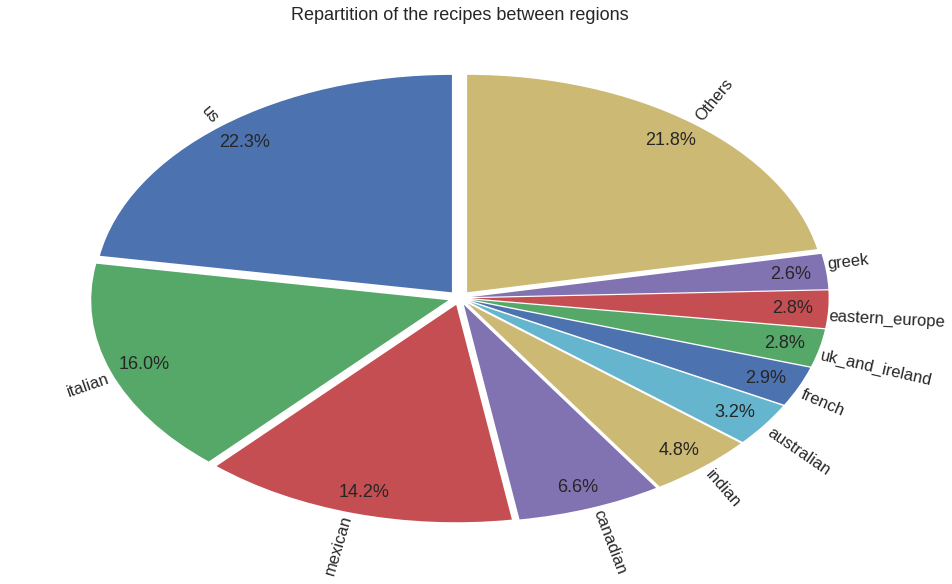

In [33]:
# Create a DF that sort the regions by their number of recipes
recipes_regions = ing_ds_region.groupby('Region').count().sort_values(by='Title', ascending=False)['Title']
recipes_regions = recipes_regions.to_frame()
recipes_regions.columns = ['Recipe Count']

# Divide the DF to group the insignificant group into one row
others_df = pd.DataFrame({'Region': 'Others', 'Recipe Count': recipes_regions.tail(26).sum()})
pie_df = pd.concat([recipes_regions.head(10).reset_index(), others_df.reset_index()])

# Pie chart
plt.pie(pie_df['Recipe Count'], explode=np.ones(len(pie_df))/30, labels=pie_df['Region'], autopct='%1.1f%%',
        shadow=False, startangle=90, labeldistance=1.0, rotatelabels= True, pctdistance=0.9)
#plt.savefig("./website/freelancer-theme/img/recipe_count_per_region.svg", format='svg')
plt.title('Repartition of the recipes between regions')
plt.show()

We see on this pie chart that US recipes is the most represented, which seemes normal since this data is coming from an american website.
We wouldn't normally do a pie chart but for our data story we think it is a funny idea to see how regions share the pie!

**We can also visualize how the recipes title are distributed, what are the more used words?**

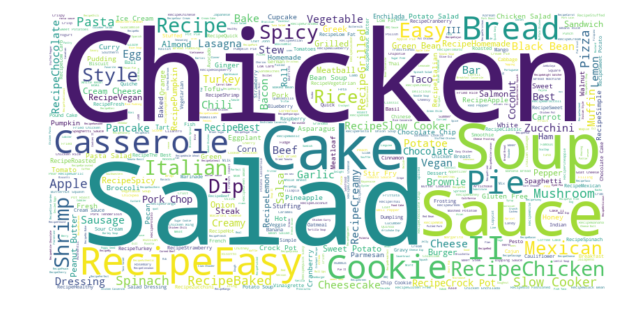

In [37]:
# Splitting every words in the titles of recipes
df = recipes_copy
titles = df.Title.tolist()
titles = ''.join(titles)

wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, width=800, height=400)\
.generate(titles)

# create coloring from image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("./website/freelancer-theme/img/Flags/titles_wordcloud.svg", format="svg", dpi=700)
plt.show()

TODO

### Ingredients Distribution
**Since we have a cleaned dataset for the ingredient, we can push the analysis further and look for the top 5 regions, which ingredients describe them best**

In [40]:
# For our top 5 regions we count the occurences of ingredients
ingredients_per_region_list = []
for region in regions:
    ing_ds_region_2 = ing_ds_region[ing_ds_region['Region'] == region]['Ingredients'].str.split(" ", expand=True) \
                                                                    .stack() \
                                                                    .map(ing_dict) \
                                                                    .value_counts()  \
                                                                    .to_frame()  \
                                                                    .reset_index()
    ing_ds_region_2['Region'] = region
    ingredients_per_region_list.append(ing_ds_region_2)

# TODO COMMENT
ingredients_per_region = pd.concat(ingredients_per_region_list)
ingredients_per_region = ingredients_per_region.set_index('Region')
ingredients_per_region.columns = ['Ingredient', 'Count']

(1136, 1600, 4)


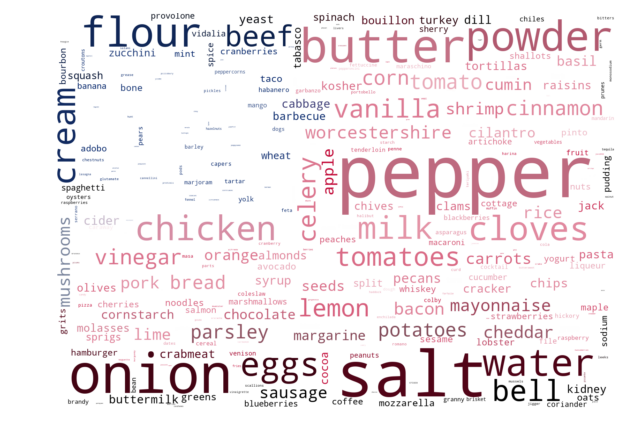

(1000, 1500, 3)


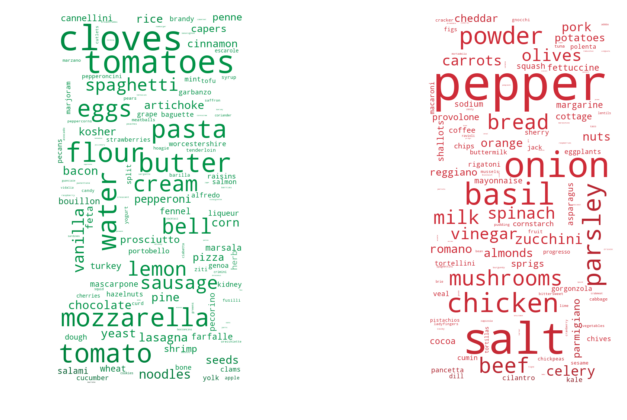

(600, 800, 4)


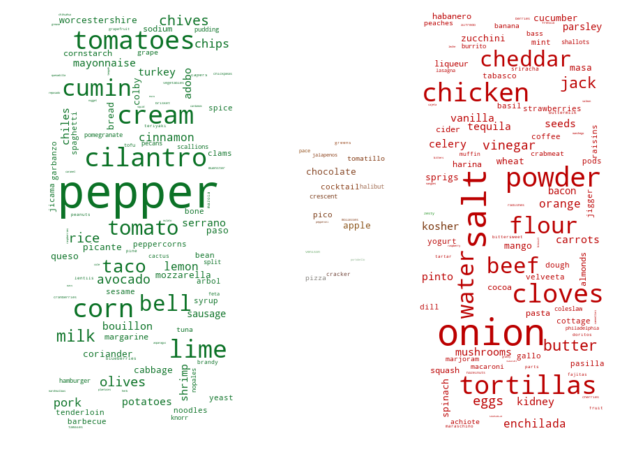

(456, 840, 3)


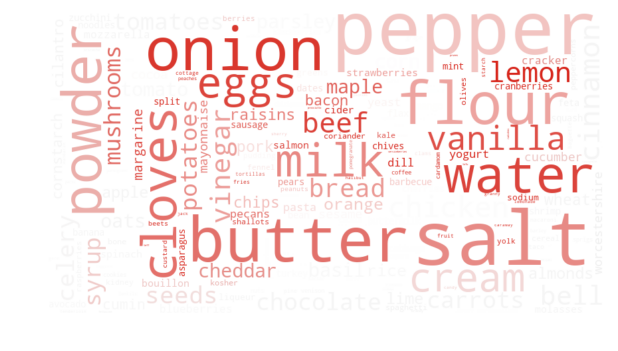

(1333, 2000, 4)


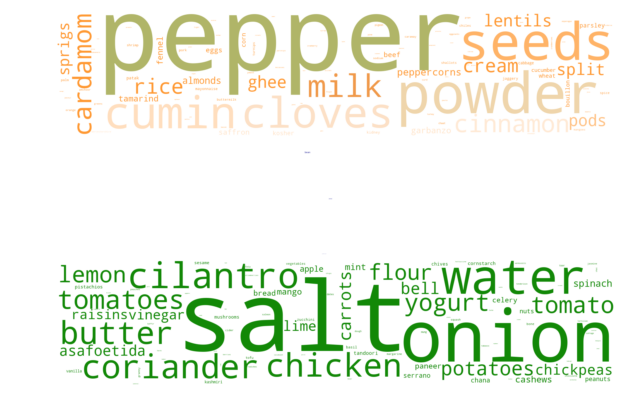

In [41]:
# TODO COMMENT
def get_region_ing(region):
    ingredients = ingredients_per_region[ingredients_per_region.index == region]
    return dict(zip(ingredients['Ingredient'], ingredients['Count']))
    

for region in top_5_regions:
    ing_list = get_region_ing(region)
    # Generate a word cloud image
    mask = np.array(Image.open("Masks/"+region+".png"))

    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask, width=800, height=400)\
    .generate_from_frequencies(ing_list)

    print(mask.shape)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    #plt.savefig("./website/freelancer-theme/img/Flags/"+region+"_ing.svg", format="svg")

    plt.show()

In the previous figure, we plot the distribution of the ingredient with respect to their region flags.
Most of the countries have salt as their first ingredients followed by pepper. But if we look in details we can clearly identify countries by their ingredients (e.g mozzarella for Italia or tortillas for Mexico)